In [ ]:
import sys
sys.path.append('..\\src')
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

---
### Set up data

In [3]:
from dce import fit, relax, signal_models, water_ex_models

# data
t = np.array([19.810000,59.430000,99.050000,138.670000,178.290000,217.910000,257.530000,297.150000,336.770000,376.390000,416.010000,455.630000,495.250000,534.870000,574.490000,614.110000,653.730000,693.350000,732.970000,772.590000,812.210000,851.830000,891.450000,931.070000,970.690000,1010.310000,1049.930000,1089.550000,1129.170000,1168.790000,1208.410000,1248.030000])
c_ap = np.array([-0.004937,0.002523,0.002364,0.005698,0.264946,0.738344,1.289008,1.826013,1.919158,1.720187,1.636699,1.423867,1.368308,1.263610,1.190378,1.132603,1.056400,1.066964,1.025331,1.015179,0.965908,0.928219,0.919029,0.892000,0.909929,0.865766,0.857195,0.831985,0.823747,0.815591,0.776007,0.783767])
s_vif = np.array([448.200000,468.000000,467.600000,476.400000,1096.200000,1994.800000,2780.600000,3364.800000,3445.600000,3268.800000,3178.200000,2941.000000,2876.200000,2746.200000,2655.800000,2584.600000,2480.200000,2492.800000,2431.400000,2418.400000,2345.200000,2297.800000,2282.800000,2247.200000,2268.600000,2199.400000,2191.000000,2154.600000,2132.200000,2125.800000,2062.400000,2068.600000])
s_tissue = np.array([474.299504,470.430226,462.800883,471.854385,486.068946,498.952013,520.548814,534.123001,529.478764,530.435190,522.399338,516.543850,518.434639,512.765030,520.986211,506.375069,506.665196,511.359073,512.912852,505.552124,507.895753,504.699393,507.365692,510.534473,504.477661,514.434639,505.516271,500.071153,510.688913,508.190292,509.127965,505.981798])
r0_tissue = relax.relaxation(r_1 = 1./1.2792, r_2s = 0.)
r0_vif = relax.relaxation(r_1 = 1./1.9183, r_2s = 0.)
k_vif, k_tissue = 0.9271, 1.1996
hct = 0.37
tr, fa_rad, te = 3.4e-3, 15.*(np.pi/180.), 1.7e-3

# time points to use for baseline
baseline_idx = [0,1,2]

# specify relaxivity
rlxy = relax.relaxivity(r_1 = 5.0, r_2s = 7.1)
# specify conc to relaxation rate model
c_to_r_model = relax.c_to_r_linear(rlxy)
# specify signal model
signal_model = signal_models.spgr(tr, fa_rad, te)

### Convert signal to enhancement

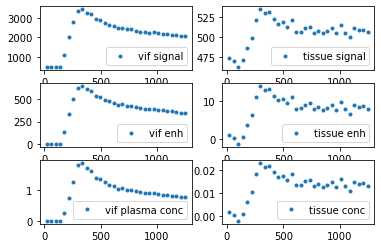

In [4]:
from dce import fit
enh_vif = fit.s_to_e(s_vif, baseline_idx)
enh_tissue = fit.s_to_e(s_tissue, baseline_idx)

c_p_vif = fit.e_to_c(enh_vif, k_vif, r0_vif, c_to_r_model, signal_model) / (1 - hct)
c_t = fit.e_to_c(enh_tissue, k_tissue, r0_tissue, c_to_r_model, signal_model)

fig, ax = plt.subplots(3,2)
ax[0,0].plot(t, s_vif, '.', label='vif signal')
ax[0,1].plot(t, s_tissue, '.', label='tissue signal')
ax[1,0].plot(t, enh_vif, '.', label='vif enh')
ax[1,1].plot(t, enh_tissue, '.', label='tissue enh')
ax[2,0].plot(t, c_p_vif, '.', label='vif plasma conc')
ax[2,1].plot(t, c_t, '.', label='tissue conc')
[a.legend() for a in ax.flatten()];

### Fit tissue concentration to pharmacokinetic model

In [5]:
from dce import fit, aifs, pk_models

aif = aifs.patient_specific(t, c_p_vif)
dt_interp_request = t[1]-t[0]

pk_model = pk_models.patlak(t, dt_interp_request, aif, hct) 
fit_opts = {'pk_pars_0': {'vp': 0.2, 'ps': 1e-4},
            't_mask': np.array(np.concatenate([np.zeros(7), np.ones(25)]),dtype=bool) }

fit.c_to_pkp(c_t, pk_model, fit_opts)

({'vp': 0.011447882716933576,
  'ps': 0.00021599858894466234,
  've': 0.9818287575921689,
  'vi': 0.0,
  'vb': 0.01817124240783107},
 array([       nan,        nan,        nan,        nan,        nan,
               nan,        nan, 0.02120044, 0.02243859, 0.02061203,
        0.01984546, 0.01761122, 0.01718073, 0.01615558, 0.01552302,
        0.0150725 , 0.01435551, 0.01460972, 0.01425824, 0.01429838,
        0.01386025, 0.01362824, 0.01364495, 0.0135043 , 0.01379425,
        0.01340198, 0.01346237, 0.01331597, 0.01327119, 0.01334143,
        0.01300261, 0.01315717]))